<a href="https://colab.research.google.com/github/matetepaps/model-classifer/blob/main/classifier_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install psycopg2-binary

In [2]:
#import important libraries

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sqlalchemy import create_engine
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os

# Download NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Database connection details (replace with actual credentials)
user = "niphemi.oyewole"
password = "W7bHIgaN1ejh"
database = "Vetassist"
host = "ep-delicate-river-a5cq94ee-pooler.us-east-2.aws.neon.tech"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Connect to Postgres database (assuming SQLAlchemy is installed)
conn_string = f"postgresql://{user}:{password}@{host}/{database}"
engine = create_engine(conn_string)

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#Function to preprocess text data
#Preprocesses text data by converting to lowercase, removing punctuation,
#tokenizing, removing stopwords, and optionally lemmatizing.
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    tokens = word_tokenize(text)  # Tokenize text
    filtered_tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]  # Lemmatize tokens
    preprocessed_text = ' '.join(lemmatized_tokens)  # Join tokens back into a string
    return preprocessed_text

In [4]:
# Load data from database
data = pd.read_sql_table("reddit_usernames_comments", engine)

# Preprocess comments
data['preprocessed_comment'] = data['comments'].apply(preprocess_text)

# Define labels based on keywords. Add as many keyword as you can provide for the label
medical_keywords = ["doctor", "physician", "surgeon", "medical school", "resident", "nurse", "doc", "medical doctor", "medicine", "med doc", "med doctor", "medical doc"]
veterinarian_keywords = ["veterinarian", "vet doc", "vetinary doc", "vet doctor", "vetinary doctor", "vet tech", "vet", "veterinary school"]

def generate_label(comment):
    for word in medical_keywords:
        if word in comment:
            return "Medical Doctor"
    for word in veterinarian_keywords:
        if word in comment:
            return "Veterinarian"
    return "Other"

In [5]:
# Generate labels for comments
data['classified_label'] = data['preprocessed_comment'].apply(generate_label)

# Split data into features (X) and labels (y)
X = data['preprocessed_comment']
y = data['classified_label']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize and train the classifier (Decision Tree)
classifier = DecisionTreeClassifier()
classifier.fit(X_train_tfidf, y_train)

# Predict labels for the testing set
y_pred = classifier.predict(X_test_tfidf)


# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

# Predict labels for all comments
all_comments_tfidf = tfidf_vectorizer.transform(data['preprocessed_comment'])
predicted_labels = classifier.predict(all_comments_tfidf)

# Add predicted labels to the DataFrame
data['predicted_label'] = predicted_labels

# Save DataFrame with predicted labels to a CSV file
data.to_csv('predicted_labels.csv', index=False)


                precision    recall  f1-score   support

Medical Doctor       0.97      0.93      0.95       158
         Other       0.98      0.98      0.98       373
  Veterinarian       0.93      0.97      0.95       125

      accuracy                           0.97       656
     macro avg       0.96      0.96      0.96       656
  weighted avg       0.97      0.97      0.97       656



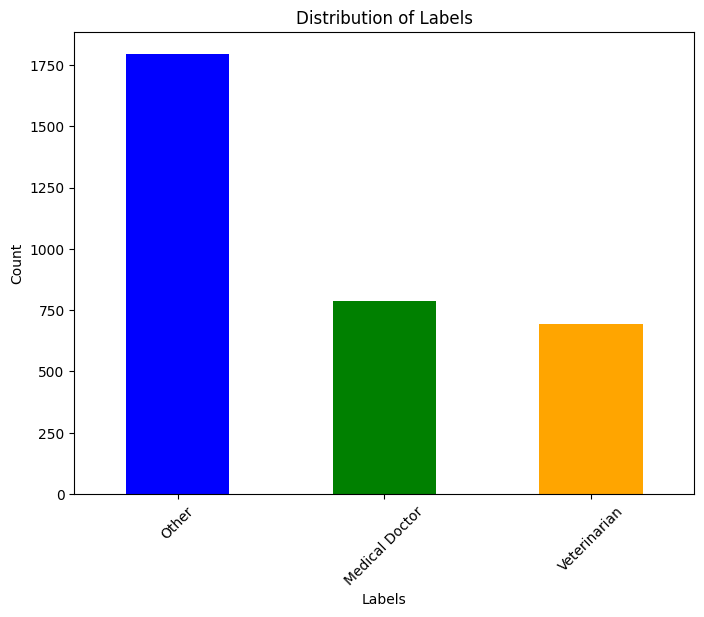

In [6]:
#Visualization of the 3 categories
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = data['classified_label'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'green', 'orange'])
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()

In [7]:
# Download the CSV file
# from google.colab import files
# files.download('predicted_labels.csc')
if os.path.exists('predicted_labels.csv'):
    # Download the Excel file
    from google.colab import files
    files.download('predicted_labels.csv')
else:
    print("Excel file not found. Please check if the file was created.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Confirming whether we choose the best classifier for this task: Let benchmark the Performance metrics result of Decision Tree against other classifier such as Logistic Regression, Support Vector Machine, Random Forests, and  neural networks**

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Initialize classifiers
logistic_regression = LogisticRegression()
svm = SVC()
random_forest = RandomForestClassifier()
neural_network = MLPClassifier()

# Train classifiers
logistic_regression.fit(X_train_tfidf, y_train)
svm.fit(X_train_tfidf, y_train)
random_forest.fit(X_train_tfidf, y_train)
neural_network.fit(X_train_tfidf, y_train)

# Predict labels for the testing set
y_pred_lr = logistic_regression.predict(X_test_tfidf)
y_pred_dt = svm.predict(X_test_tfidf)
y_pred_rf = random_forest.predict(X_test_tfidf)
y_pred_nn = neural_network.predict(X_test_tfidf)

# Evaluate the performance of each classifier
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("Support Vector Machine:")
print(classification_report(y_test, y_pred_dt))
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Neural Network:")
print(classification_report(y_test, y_pred_nn))

Logistic Regression:
                precision    recall  f1-score   support

Medical Doctor       0.82      0.59      0.69       158
         Other       0.83      0.99      0.90       373
  Veterinarian       0.85      0.65      0.74       125

      accuracy                           0.83       656
     macro avg       0.83      0.74      0.78       656
  weighted avg       0.83      0.83      0.82       656

Support Vector Machine:
                precision    recall  f1-score   support

Medical Doctor       0.86      0.55      0.67       158
         Other       0.81      0.99      0.89       373
  Veterinarian       0.83      0.68      0.75       125

      accuracy                           0.82       656
     macro avg       0.83      0.74      0.77       656
  weighted avg       0.83      0.82      0.81       656

Random Forest:
                precision    recall  f1-score   support

Medical Doctor       0.79      0.54      0.64       158
         Other       0.85      0.99  

Decision Tree classifier perform better than the rest of classifiers.

- `Precision`, among all instances predicted as `"Medical Doctor"` by the classifier, `97%` of them are actually "Medical Doctor."`
- `Recall`, among all actual instances of "Other," the classifier correctly identified `98%` of them.
- `Accuraccy`, the overall accuracy of the Decision Tree classifier is 0.97, indicating that it correctly classified `97%` of all instances in the test dataset.

The Decision Tree classifier performs well across all classes, with high precision, recall, and F1-score values. The high accuracy indicates that the classifier is effective in distinguishing between the three classes in the dataset.